组员：楚杰 253108120144
贡献：100%
github仓库：https://github.com/BXZZcj/Unpredictivity_Computation.git

本文提出了一种基于深度学习衡量物理系统不可测性的方法。

物理系统在连续时间内不断变化，环境不会为智能体的决策而暂停，学习算法需要考虑到这一点，它们部署到真实世界中时，需要在线地、实时地根据最新的物理世界状态更新自己的输出。
但是，模型的计算延迟是不可避免的，它建造了物理世界最新状态和模型最新输出之间的Gap，这在变化剧烈的环境中，会带来极大的危害。
例如，一个任务是机器人打乒乓球，我们的感知算法输入当前最新的RGB图像，输出对应的乒乓球的最新位置，喂部署到机器人上的机器人策略，机器人策略根据输入的乒乓球最新位置来决定它手中的球拍该移动到什么地方。但假如，感知算法的计算延迟很大，则$t$输入的RGB图像，要到$t+\delta_{t}$时刻才能输出，$\delta_{t}$即为感知模型的计算延迟，等到感知模型输出时，乒乓球在物理世界中已经飞行了$\delta_{t}$时间了，感知模型输出的乒乓球位置早已过时，则会导致下有的机器人策略做出迟钝的动作，使得打乒乓球任务失败。这就是计算延迟带来的危害。

那要如何弥补不可避免的计算延迟呢？最直接，且最广为人们所用的方法是预测。具体来说，模型不仅仅输出当前状态估计，而是要输出一个对未来的预测。在打乒乓球的例子中，一个带有预测功能的感知模型，在$t$时刻输入RGB图像，它输出的将不是$t$时刻的乒乓球位置，而是预测出来的$t+\delta_{t}$时刻的乒乓球位置。这样一来，当耗时$\delta_{t}$的计算完成时，模型输出的正好是物理世界中乒乓球的最新状态，这就弥补了计算延迟。
然而，预测并非万能的灵丹妙药。预测的准确性高度依赖于物理系统本身的可预测性。一个物体的运动轨迹越是规律、越是遵循固定的物理定律，对它的未来状态进行预测就越准确。反之，如果一个系统的行为充满了随机性和突变，那么任何预测都将伴随着巨大的不确定性。

因此，对系统不可预测性的量化评估，能在对问题建模之前就回答“这个问题有多大挑战性？是否值得预测？计算延迟会带来多大的危害？”。它让我们针对不同的应用场景，设计不同的算法，采用不同的设备。例如，一个流水线上，机械臂要抓取物体并放进篮筐里，若产品匀速且间隔均匀地移动，则环境的可预测性是很高的，我们可以手写规则控制机械臂，甚至用不上基于学习的方法。又例如，我们要对一只快速扑腾翅膀的飞鸟做单目标跟踪，则目标的不可预测性是很高的，因为飞鸟的飞行轨迹随心所欲，身体还会形变，我们最好放弃预测性的方法，直接加大算力，提高目标跟踪模型推理速度。总的来说，衡量系统状态的不可预测性，能使得我们从盲目的模型试错中解脱出来，转向一种更具洞察力的、自顶向下的战略性设计。

那要如何衡量一个系统状态的不可预测性呢？常用的有如下方法：
1. 样本熵(Sample Entropy): 通过计算序列中一个短模式能够持续匹配下一个数据点的概率，来衡量该序列产生新模式的速率和不可预测性。
2. 近似熵(Approximate Entropy): 与样本熵类似，它也是通过衡量模式的可持续性来量化序列的规律性，但由于在其计算中包含了与自身的比较，因此结果会略微偏向于规律性。
3. 卡尔曼滤波(Kalman Filter, KF): 通过将一个预设的简单运动模型（如匀速运动）的预测与实际观测值进行比较，用两者之间的平均差距（残差）来衡量真实运动轨迹偏离简单规律的程度。

但是，这些常用方法都是基于规则衡量系统状态变化的不可预测性，它们会遇到很多corner case。例如，对于一个物体运动的bounding box [x,y,w,h]序列，假如这个物体是做匀加速直线运动，则我们直接用样本熵计算出的不可预测性，肯定是不小的，但假如我们先对这个序列做一阶或二阶差分，再对得到的新序列用样本熵计算不可预测性，那值会很小。那么，这个均加速直线运动的物体不可预测性高还是不高呢？这就是一个corner case。再例如，一个风扇的扇叶在做匀速圆周运动，我们可以直接用4个标量(圆心坐标[x,y]，扇叶长度l,扇叶转动角速度$\omega$)就确定扇叶尖端在2D平面上的运动轨迹，但假如我们用一阶KF去衡量它的不可预测性，那衡量出来就很大了，这也是一个corner case。

但是人脑可以靠直觉一定程度上覆盖掉这些corner case，例如，对于上述两种corner case，我们可以很快速地识别出它们的不可预测性实际上是比较低的。受此启发，我们认为，可以用learning-based/data-driven的方式来衡量不可预测性。一个直接的方法是：我们用神经网络(eg.LSTM)去拟合一段系统状态变化序列(eg. [x,y,w,h]序列)，根据神经网络收敛的loss来衡量不可预测性。我们通过实验发现，这种learning-based/data-driven metric比样本熵、近似熵、KF这类rule-based metric更加可靠。

我们参考了 [Bridging the Latency Gap with a Continuous Stream Evaluation Framework in Event-Driven Perception](https://github.com/ispc-lab/STARE) 这篇论文，对它提供的目标跟踪数据集(每个样本的annotation均为一段[x,y,w,h]序列)衡量不可预测性，用它提出的低计算延迟目标跟踪模型在该数据集上的性能来验证learning-based metric的可靠性。具体来说，我们分别用一个LSTM去拟合每一个样本的bounding box序列，用训练loss作为learning-based metric的结果，同时，我们还对每一个序列计算了样本熵、近似熵、KF的结果。我们合理假设目标跟踪模型在每个样本上在线运行的精确度与该样本的ground truth的不可预测性呈现正相关，则，一个metrics计算出来的结果与目标跟踪模型的精确度越正相关，这个metric就越可靠。
我们还要声明的是：我们不能直接用目标跟踪模型来衡量每个样本的不可预测性，因为考虑到模型参数、预训练数据、输入要求，训练一个目标跟踪模型代价昂贵，且它只能衡量一个bounding box序列的不可预测性。而用简单的LSTM,代价较低，且理论上可以处理任意系统状态变化序列。

下面代码将下载 Bridging the Latency Gap with a Continuous Stream Evaluation Framework in Event-Driven Perception 中的ESOT500-L高帧率标注的目标跟踪数据集，但我们不使用数据集中的视频，仅使用数据集的标注，且我们仅使用test split。这里的标注是一个场景中目标物体的500Hz频率记录下来的位置，即bounding box: [x,y,w,h]。

In [ ]:
# 下载数据集

from huggingface_hub import snapshot_download
import os

repo_id = "sii-geai-lab/ESOT500"
path_in_repo = "ESOT500-L/anno_t"

local_dir = "./ESOT500-L"

print(f"开始从仓库 '{repo_id}' 下载文件夹 '{path_in_repo}'...")
print(f"文件将被保存到本地路径: '{os.path.abspath(local_dir)}'")

snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    allow_patterns=f"{path_in_repo}/*",
    local_dir=local_dir,
    local_dir_use_symlinks=False # 建议设为False，直接下载文件而不是链接
)

print("\n下载完成！")

In [ ]:
%%bash

cd ./ESOT500-L
wget https://huggingface.co/datasets/sii-geai-lab/ESOT500/resolve/main/ESOT500-L/test.txt

下面将计算ESOT500-L中test split的bounding box序列的样本熵：

In [ ]:
import numpy as np
import math
import os
from datetime import datetime

# ==============================================================================
#  核心计算函数 (版本 2：增加了归一化处理)
# ==============================================================================

def normalize_bbox(bbox, img_width, img_height):
    """
    将单个 bounding box 归一化到 [0, 1] 范围。
    bbox 格式: [x, y, w, h]
    """
    x, y, w, h = bbox
    # 防止除以零
    if img_width == 0 or img_height == 0:
        return [0., 0., 0., 0.]
    
    norm_x = x / img_width
    norm_y = y / img_height
    norm_w = w / img_width
    norm_h = h / img_height
    return [norm_x, norm_y, norm_w, norm_h]

def calculate_iou(box1, box2):
    """
    计算两个 bounding box 的 IoU (Intersection over Union)。
    box 格式: [x, y, w, h]
    这里的 box 已经是归一化后的了。
    """
    box1_x1, box1_y1 = box1[0], box1[1]
    box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    box2_x1, box2_y1 = box2[0], box2[1]
    box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]

    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0

    iou = inter_area / union_area
    return iou

def sample_entropy_iou(bbox_sequence, m, r):
    """
    计算 bounding box 序列的样本熵。
    使用 1-IoU 作为两个 bounding box 之间的距离。
    """
    n = len(bbox_sequence)
    if n < m + 1:
        print(f"  -> 警告: 序列长度 ({n}) 过短，无法使用 m={m} 计算样本熵。跳过。")
        return None

    A = 0
    B = 0
    
    for i in range(n - m):
        for j in range(i + 1, n - m):
            is_match_m = True
            for k in range(m):
                dist = 1.0 - calculate_iou(bbox_sequence[i + k], bbox_sequence[j + k])
                if dist >= r:
                    is_match_m = False
                    break
            
            if is_match_m:
                B += 1
                dist_next = 1.0 - calculate_iou(bbox_sequence[i + m], bbox_sequence[j + m])
                if dist_next < r:
                    A += 1

    if B == 0 or A == 0:
        return float('inf')
        
    return -math.log(A / B)

# ==============================================================================
#  文件处理和主逻辑 (版本 2：增加归一化和结果保存)
# ==============================================================================

def process_sequences(data_folder_path, sequence_list_path, output_file_path,
                      img_width, img_height, m, r):
    """
    读取序列列表，计算每个序列的样本熵，打印结果并保存到文件。
    """
    print("--- 开始计算序列的样本熵 ---")
    print(f"数据文件夹: {data_folder_path}")
    print(f"序列列表文件: {sequence_list_path}")
    print(f"图像尺寸 (W x H): {img_width} x {img_height}")
    print(f"参数: m = {m}, r = {r}\n")
    
    # 存储结果的列表
    results = []

    try:
        with open(sequence_list_path, 'r') as f:
            sequence_names = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"错误: 找不到序列列表文件 '{sequence_list_path}'")
        return

    for seq_name in sequence_names:
        file_path = os.path.join(data_folder_path, f"{seq_name}.txt")
        
        if not os.path.exists(file_path):
            print(f"警告: 找不到序列文件 '{file_path}'。跳过。")
            continue

        raw_bbox_sequence = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        x, y, w, h = map(int, parts[1:5])
                        raw_bbox_sequence.append([x, y, w, h])
        except Exception as e:
            print(f"错误: 读取或解析文件 '{file_path}' 时出错: {e}。跳过。")
            continue

        if not raw_bbox_sequence:
            print(f"警告: 文件 '{file_path}' 为空或格式不正确。跳过。")
            continue
        
        # *** 新增步骤：对整个序列进行归一化 ***
        normalized_bbox_sequence = [
            normalize_bbox(bbox, img_width, img_height) for bbox in raw_bbox_sequence
        ]

        print(f"正在处理序列: '{seq_name}' ({len(normalized_bbox_sequence)} 帧)...")
        sampen = sample_entropy_iou(normalized_bbox_sequence, m, r)

        if sampen is not None:
            results.append((seq_name, sampen))
            if sampen == float('inf'):
                 print(f"  -> 结果: 样本熵 = inf\n")
            else:
                 print(f"  -> 结果: 样本熵 = {sampen:.4f}\n")

    # *** 新增步骤：将结果保存到文件 ***
    if results:
        try:
            with open(output_file_path, 'w') as f:
                # 写入一些元数据信息
                f.write(f"# 样本熵计算结果\n")
                f.write(f"# 计算时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"# 参数: m={m}, r={r}\n")
                f.write(f"# 图像尺寸 (W x H): {img_width} x {img_height}\n")
                f.write("# ---\n")
                # 写入数据
                for seq_name, entropy_value in results:
                    f.write(f"{seq_name}: {entropy_value}\n")
            print(f"--- 所有计算完成。结果已成功保存到: '{output_file_path}' ---")
        except Exception as e:
            print(f"错误: 无法将结果写入文件 '{output_file_path}': {e}")
    else:
        print("--- 计算完成，但没有生成任何结果。---")


# ==============================================================================
#  配置和运行
# ==============================================================================
if __name__ == "__main__":
    
    # --- 请在这里修改您的配置 ---
    
    # 1. 存放 {sequence name}.txt 文件的数据文件夹路径
    DATA_FOLDER_PATH = "./ESOT500-L/anno_t"

    # 2. 存放待处理序列名称的 test.txt 文件的完整路径
    SEQUENCE_LIST_PATH = "./ESOT500-L/test.txt"

    # 3. 保存结果的输出文件路径
    OUTPUT_FILE_PATH = "./ESOT500-L/sampen_results.txt"

    # 4. 原始图像的尺寸
    IMAGE_WIDTH = 346
    IMAGE_HEIGHT = 260
    
    # 5. 样本熵的参数
    M = 2
    R = 0.4

    # --- 配置结束 ---

    # 检查路径是否为默认值
    if any("path/to/your" in p for p in [DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! 错误：请先在代码中修改 DATA_FOLDER_PATH,         !!!")
        print("!!!       SEQUENCE_LIST_PATH, 和 OUTPUT_FILE_PATH    !!!")
        print("!!!       为您的实际文件路径。                       !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        process_sequences(DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH,
                          IMAGE_WIDTH, IMAGE_HEIGHT, M, R)

--- 开始计算序列的样本熵 ---
数据文件夹: ./ESOT500-L/anno_t
序列列表文件: ./ESOT500-L/test.txt
图像尺寸 (W x H): 346 x 260
参数: m = 2, r = 0.4

正在处理序列: 'airplane5' (6140 帧)...
  -> 结果: 样本熵 = 0.0325

正在处理序列: 'animal2' (6139 帧)...
  -> 结果: 样本熵 = 0.0307

正在处理序列: 'bag6' (5740 帧)...
  -> 结果: 样本熵 = 0.0085

正在处理序列: 'ball15' (6230 帧)...
  -> 结果: 样本熵 = 0.0377

正在处理序列: 'bike8' (5660 帧)...
  -> 结果: 样本熵 = 0.0144

正在处理序列: 'book3' (6188 帧)...


下面将计算ESOT500-L中test split的bounding box序列的近似熵：

In [5]:
import numpy as np
import math
import os
from datetime import datetime

# ==============================================================================
#  核心计算函数 (版本 2：增加了归一化处理)
# ==============================================================================

def normalize_bbox(bbox, img_width, img_height):
    """
    将单个 bounding box 归一化到 [0, 1] 范围。
    bbox 格式: [x, y, w, h]
    """
    x, y, w, h = bbox
    if img_width == 0 or img_height == 0:
        return [0., 0., 0., 0.]
    
    norm_x = x / img_width
    norm_y = y / img_height
    norm_w = w / img_width
    norm_h = h / img_height
    return [norm_x, norm_y, norm_w, norm_h]

def calculate_iou(box1, box2):
    """
    计算两个 bounding box 的 IoU (Intersection over Union)。
    box 格式: [x, y, w, h] (已归一化)
    """
    box1_x1, box1_y1 = box1[0], box1[1]
    box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    box2_x1, box2_y1 = box2[0], box2[1]
    box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]

    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0

    iou = inter_area / union_area
    return iou

def approximate_entropy_iou(bbox_sequence, m, r):
    """
    计算 bounding box 序列的近似熵 (Approximate Entropy, ApEn)。
    使用 1-IoU 作为两个 bounding box 之间的距离。

    ApEn(m, r) = Phi(m, r) - Phi(m+1, r)
    """

    def _phi(m_val):
        n = len(bbox_sequence)
        num_templates = n - m_val + 1
        
        # C_i(m, r) 是与模板 i 相似的模板所占的比例
        # C_i(m, r) = (number of j where d[X_i, X_j] <= r) / num_templates
        C = []
        for i in range(num_templates):
            match_count = 0
            # ApEn 包含与自身的比较，所以 j 从 0 开始
            for j in range(num_templates):
                # 检查模板 X(i) 和 X(j) 是否相似
                is_match = True
                for k in range(m_val):
                    dist = 1.0 - calculate_iou(bbox_sequence[i + k], bbox_sequence[j + k])
                    if dist >= r:
                        is_match = False
                        break
                if is_match:
                    match_count += 1
            
            # 计算 C_i
            C.append(match_count / num_templates)

        # Phi(m, r) 是 log(C_i) 的平均值
        return np.mean(np.log(C))

    n = len(bbox_sequence)
    if n < m + 2:
        print(f"  -> 警告: 序列长度 ({n}) 过短，无法使用 m={m} 计算近似熵。跳过。")
        return None

    phi_m = _phi(m)
    phi_m_plus_1 = _phi(m + 1)

    return phi_m - phi_m_plus_1


# ==============================================================================
#  文件处理和主逻辑
# ==============================================================================

def process_sequences(data_folder_path, sequence_list_path, output_file_path,
                      img_width, img_height, m, r):
    """
    读取序列列表，计算每个序列的近似熵，打印结果并保存到文件。
    """
    print("--- 开始计算序列的近似熵 (ApEn) ---")
    print(f"数据文件夹: {data_folder_path}")
    print(f"序列列表文件: {sequence_list_path}")
    print(f"图像尺寸 (W x H): {img_width} x {img_height}")
    print(f"参数: m = {m}, r = {r}\n")
    
    results = []

    try:
        with open(sequence_list_path, 'r') as f:
            sequence_names = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"错误: 找不到序列列表文件 '{sequence_list_path}'")
        return

    for seq_name in sequence_names:
        file_path = os.path.join(data_folder_path, f"{seq_name}.txt")
        
        if not os.path.exists(file_path):
            print(f"警告: 找不到序列文件 '{file_path}'。跳过。")
            continue

        raw_bbox_sequence = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        x, y, w, h = map(int, parts[1:5])
                        raw_bbox_sequence.append([x, y, w, h])
        except Exception as e:
            print(f"错误: 读取或解析文件 '{file_path}' 时出错: {e}。跳过。")
            continue

        if not raw_bbox_sequence:
            print(f"警告: 文件 '{file_path}' 为空或格式不正确。跳过。")
            continue
        
        normalized_bbox_sequence = [
            normalize_bbox(bbox, img_width, img_height) for bbox in raw_bbox_sequence
        ]

        print(f"正在处理序列: '{seq_name}' ({len(normalized_bbox_sequence)} 帧)...")
        apen = approximate_entropy_iou(normalized_bbox_sequence, m, r)

        if apen is not None:
            results.append((seq_name, apen))
            print(f"  -> 结果: 近似熵 = {apen:.4f}\n")

    if results:
        try:
            with open(output_file_path, 'w') as f:
                f.write(f"# 近似熵 (ApEn) 计算结果\n")
                f.write(f"# 计算时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"# 参数: m={m}, r={r}\n")
                f.write(f"# 图像尺寸 (W x H): {img_width} x {img_height}\n")
                f.write("# ---\n")
                for seq_name, entropy_value in results:
                    f.write(f"{seq_name}: {entropy_value}\n")
            print(f"--- 所有计算完成。结果已成功保存到: '{output_file_path}' ---")
        except Exception as e:
            print(f"错误: 无法将结果写入文件 '{output_file_path}': {e}")
    else:
        print("--- 计算完成，但没有生成任何结果。---")


# ==============================================================================
#  配置和运行
# ==============================================================================
if __name__ == "__main__":
    
    # --- 请在这里修改您的配置 ---
    
    # 1. 存放 {sequence name}.txt 文件的数据文件夹路径
    DATA_FOLDER_PATH = "./ESOT500-L/anno_t"

    # 2. 存放待处理序列名称的 test.txt 文件的完整路径
    SEQUENCE_LIST_PATH = "./ESOT500-L/test.txt"

    # 3. 保存结果的输出文件路径
    OUTPUT_FILE_PATH = "./ESOT500-L/apen_results.txt"

    # 4. 原始图像的尺寸
    IMAGE_WIDTH = 346
    IMAGE_HEIGHT = 260
    
    # 5. 近似熵的参数
    M = 2
    R = 0.4

    # --- 配置结束 ---

    # 检查路径是否为默认值
    if any("path/to/your" in p for p in [DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! 错误：请先在代码中修改 DATA_FOLDER_PATH,         !!!")
        print("!!!       SEQUENCE_LIST_PATH, 和 OUTPUT_FILE_PATH    !!!")
        print("!!!       为您的实际文件路径。                       !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        process_sequences(DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH,
                          IMAGE_WIDTH, IMAGE_HEIGHT, M, R)

--- 开始计算序列的近似熵 (ApEn) ---
数据文件夹: ./ESOT500-L/anno_t
序列列表文件: ./ESOT500-L/test.txt
图像尺寸 (W x H): 346 x 260
参数: m = 2, r = 0.4

正在处理序列: 'airplane5' (6140 帧)...
  -> 结果: 近似熵 = 0.0526

正在处理序列: 'animal2' (6139 帧)...
  -> 结果: 近似熵 = 0.0433

正在处理序列: 'bag6' (5740 帧)...
  -> 结果: 近似熵 = 0.0084

正在处理序列: 'ball15' (6230 帧)...
  -> 结果: 近似熵 = 0.0513

正在处理序列: 'bike8' (5660 帧)...
  -> 结果: 近似熵 = 0.0165

正在处理序列: 'book3' (6188 帧)...
  -> 结果: 近似熵 = 0.0543

正在处理序列: 'book13' (5900 帧)...
  -> 结果: 近似熵 = 0.0171

正在处理序列: 'box6' (5550 帧)...
  -> 结果: 近似熵 = 0.0900

正在处理序列: 'cap8' (5960 帧)...
  -> 结果: 近似熵 = 0.1336

正在处理序列: 'car14' (5990 帧)...
  -> 结果: 近似熵 = 0.0075

正在处理序列: 'car24' (6319 帧)...
  -> 结果: 近似熵 = 0.0054

正在处理序列: 'car33' (5946 帧)...
  -> 结果: 近似熵 = 0.0056

正在处理序列: 'car40' (6040 帧)...
  -> 结果: 近似熵 = 0.0015

正在处理序列: 'cup10' (5329 帧)...
  -> 结果: 近似熵 = 0.0175

正在处理序列: 'extra8' (5530 帧)...
  -> 结果: 近似熵 = 0.0198

正在处理序列: 'extra9' (5400 帧)...
  -> 结果: 近似熵 = 0.0121

正在处理序列: 'flag3' (6413 帧)...
  -> 结果: 近似熵 = 0.0488

正

下面将用二阶卡尔曼滤波来衡量ESOT500-L中test split的bounding box序列的不可预测性：

In [2]:
import numpy as np
import os
from datetime import datetime

# ==============================================================================
#  卡尔曼滤波器类 (二阶 - 恒定加速度模型)
# ==============================================================================

class KalmanFilterCA:
    """
    一个用于 Bounding Box 追踪的二阶卡尔曼滤波器 (恒定加速度模型)。
    状态向量 x: [cx, cy, w, h, vx, vy, vw, vh, ax, ay, aw, ah] (12维)
    观测向量 z: [cx, cy, w, h] (4维)
    """
    def __init__(self, dt=1.0):
        # 时间步长
        self.dt = dt

        # --- 状态转移矩阵 F (12x12) ---
        # 定义了状态如何随时间演化
        # pos_new = pos + vel*dt + 0.5*acc*dt^2
        # vel_new = vel + acc*dt
        # acc_new = acc
        f_block = np.array([[1, self.dt, 0.5 * self.dt**2],
                            [0, 1,      self.dt],
                            [0, 0,      1]])
        self.F = np.kron(np.eye(4), f_block) # 将 3x3 块复制 4 次到对角线上

        # --- 观测矩阵 H (4x12) ---
        # 定义了如何从状态向量中提取出观测值
        h_block = np.array([1, 0, 0])
        self.H = np.kron(np.eye(4), h_block)

        # --- 过程噪声协方差 Q (12x12) ---
        # 模型的不确定性 (加速度不是完美的恒定)
        # 给予加速度项更高的不确定性
        q_block = np.diag([0.01, 0.1, 1.0])
        self.Q = np.kron(np.eye(4), q_block) * 0.1

        # --- 观测噪声协方差 R (4x4) ---
        # 观测值的不确定性。因为我们使用 Ground Truth，所以设为一个非常小的值。
        self.R = np.eye(4) * 1e-6

        # --- 状态向量 x 和 状态协方差矩阵 P ---
        self.x = np.zeros((12, 1))
        self.P = np.eye(12) * 100  # 初始状态有很大的不确定性

    def predict(self):
        """执行预测步骤"""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        """
        执行更新步骤。
        z 是观测到的 [cx, cy, w, h] 向量。
        返回残差向量 (innovation)。
        """
        # --- 计算残差 (Innovation) ---
        z = np.array(z).reshape(4, 1)
        y = z - self.H @ self.x # 这就是我们需要的残差！
        
        # --- 更新 ---
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(12)
        self.P = (I - K @ self.H) @ self.P
        
        return y.flatten() # 返回一个扁平化的 1D 数组

# ==============================================================================
#  文件处理和主逻辑
# ==============================================================================

def process_sequences(data_folder_path, sequence_list_path, output_file_path):
    """
    读取序列列表，使用卡尔曼滤波计算每个序列的不可预测性，并保存结果。
    """
    print("--- 开始使用二阶卡尔曼滤波计算不可预测性 ---")
    print(f"数据文件夹: {data_folder_path}")
    print(f"序列列表文件: {sequence_list_path}\n")

    results = []

    try:
        with open(sequence_list_path, 'r') as f:
            sequence_names = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"错误: 找不到序列列表文件 '{sequence_list_path}'")
        return

    for seq_name in sequence_names:
        file_path = os.path.join(data_folder_path, f"{seq_name}.txt")
        
        if not os.path.exists(file_path):
            print(f"警告: 找不到序列文件 '{file_path}'。跳过。")
            continue

        bbox_sequence = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        x, y, w, h = map(int, parts[1:5])
                        # 转换为中心点坐标 [cx, cy, w, h]
                        cx = x + w / 2
                        cy = y + h / 2
                        bbox_sequence.append([cx, cy, w, h])
        except Exception as e:
            print(f"错误: 读取或解析文件 '{file_path}' 时出错: {e}。跳过。")
            continue

        if len(bbox_sequence) < 2:
            print(f"警告: 序列 '{seq_name}' 帧数过少 ({len(bbox_sequence)} 帧)，无法计算。跳过。")
            continue

        print(f"正在处理序列: '{seq_name}' ({len(bbox_sequence)} 帧)...")
        
        # --- KF 计算流程 ---
        kf = KalmanFilterCA(dt=1.0) # 假设帧之间时间间隔为1
        
        # 使用第一帧来初始化状态
        initial_state = bbox_sequence[0]
        kf.x[:4, 0] = initial_state
        
        residuals_norms = []
        # 从第二帧开始循环
        for i in range(1, len(bbox_sequence)):
            kf.predict()
            residual_vec = kf.update(bbox_sequence[i])
            # 计算残差向量的欧氏范数 (L2 norm) 作为误差大小
            residual_norm = np.linalg.norm(residual_vec)
            residuals_norms.append(residual_norm)
            
        # 不可预测性得分 = 平均残差
        if not residuals_norms:
             unpredictability_score = 0.0
        else:
             unpredictability_score = np.mean(residuals_norms)
        
        results.append((seq_name, unpredictability_score))
        print(f"  -> 结果: 平均残差 (不可预测性得分) = {unpredictability_score:.4f}\n")

    # --- 保存结果到文件 ---
    if results:
        try:
            with open(output_file_path, 'w') as f:
                f.write(f"# 二阶卡尔曼滤波 (CA模型) 不可预测性得分\n")
                f.write(f"# 得分 = 预测与 Ground Truth 之间的平均残差范数\n")
                f.write(f"# 计算时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("# ---\n")
                for seq_name, score in results:
                    f.write(f"{seq_name}: {score}\n")
            print(f"--- 所有计算完成。结果已成功保存到: '{output_file_path}' ---")
        except Exception as e:
            print(f"错误: 无法将结果写入文件 '{output_file_path}': {e}")
    else:
        print("--- 计算完成，但没有生成任何结果。---")


# ==============================================================================
#  配置和运行
# ==============================================================================
if __name__ == "__main__":
    
    # --- 请在这里修改您的配置 ---
    
    # 1. 存放 {sequence name}.txt 文件的数据文件夹路径
    DATA_FOLDER_PATH = "./ESOT500-L/anno_t"

    # 2. 存放待处理序列名称的 test.txt 文件的完整路径
    SEQUENCE_LIST_PATH = "./ESOT500-L/test.txt"

    # 3. 保存结果的输出文件路径
    OUTPUT_FILE_PATH = "./ESOT500-L/kf_results.txt"

    # --- 配置结束 ---

    # 检查路径是否为默认值
    if any("path/to/your" in p for p in [DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! 错误：请先在代码中修改 DATA_FOLDER_PATH,         !!!")
        print("!!!       SEQUENCE_LIST_PATH, 和 OUTPUT_FILE_PATH    !!!")
        print("!!!       为您的实际文件路径。                       !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        process_sequences(DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH)

--- 开始使用二阶卡尔曼滤波计算不可预测性 ---
数据文件夹: ./ESOT500-L/anno_t
序列列表文件: ./ESOT500-L/test.txt

正在处理序列: 'airplane5' (6140 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 9.0906

正在处理序列: 'animal2' (6139 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 1.8669

正在处理序列: 'bag6' (5740 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 1.9914

正在处理序列: 'ball15' (6230 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 2.7582

正在处理序列: 'bike8' (5660 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 1.5836

正在处理序列: 'book3' (6188 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 7.1746

正在处理序列: 'book13' (5900 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 2.5649

正在处理序列: 'box6' (5550 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 4.5154

正在处理序列: 'cap8' (5960 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 8.6924

正在处理序列: 'car14' (5990 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 1.3085

正在处理序列: 'car24' (6319 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 1.4606

正在处理序列: 'car33' (5946 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 0.9330

正在处理序列: 'car40' (6040 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 0.9113

正在处理序列: 'cup10' (5329 帧)...
  -> 结果: 平均残差 (不可预测性得分) = 3.0340

正在处理序列: 'extra8' (5530 帧)...
  -> 结果: 平均残差 (

下面将用LSTM在ESOT500-L中test split的bounding box序列上拟合的loss来衡量其不可预测性：

In [4]:
import numpy as np
import os
import torch
import torch.nn as nn
from datetime import datetime

# ==============================================================================
#  1. 配置部分 (请在这里修改您的设置)
# ==============================================================================

# a) 存放 {sequence name}.txt 文件的数据文件夹路径
DATA_FOLDER_PATH = "./ESOT500-L/anno_t"

# b) 存放待处理序列名称的 test.txt 文件的完整路径
SEQUENCE_LIST_PATH = "./ESOT500-L/test.txt"

# c) 保存结果的输出文件路径
OUTPUT_FILE_PATH = "./ESOT500-L/lstm_loss_results.txt"

# d) 原始图像的尺寸 (用于归一化)
IMAGE_WIDTH = 346
IMAGE_HEIGHT = 260

# e) LSTM 模型和训练参数 (将对每个序列使用相同的参数)
LOOK_BACK = 10
EPOCHS = 100
HIDDEN_UNITS = 50
LEARNING_RATE = 0.001


# ==============================================================================
#  2. 辅助函数和模型定义 (通常无需修改)
# ==============================================================================

def load_and_normalize_sequence(file_path, img_width, img_height):
    """加载并归一化单个序列文件。"""
    if not os.path.exists(file_path):
        print(f"  -> 错误: 找不到文件 '{file_path}'")
        return None
    
    raw_bboxes = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip(): continue
            parts = line.strip().split()
            if len(parts) >= 5:
                x, y, w, h = map(int, parts[1:5])
                raw_bboxes.append([x, y, w, h])
    
    normalized_bboxes = [
        [bbox[0]/img_width, bbox[1]/img_height, bbox[2]/img_width, bbox[3]/img_height]
        for bbox in raw_bboxes
    ]
    return np.array(normalized_bboxes)

def create_dataset(data, look_back):
    """将时间序列转换为 (输入, 输出) 对。"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, :])
    return np.array(X), np.array(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        prediction = self.linear(last_time_step_out)
        return prediction

def train_lstm_on_sequence(sequence_data):
    """在一个序列上训练一个新的 LSTM 模型并返回最终损失。"""
    if len(sequence_data) <= LOOK_BACK:
        print(f"  -> 警告: 序列长度 ({len(sequence_data)}) 过短，无法训练。跳过。")
        return None

    # 准备数据集
    X_data, y_data = create_dataset(sequence_data, LOOK_BACK)
    X_train = torch.from_numpy(X_data).float()
    y_train = torch.from_numpy(y_data).float()
    
    # 构建全新的模型
    num_features = X_train.shape[2]
    model = LSTMModel(input_size=num_features, hidden_size=HIDDEN_UNITS, output_size=num_features)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练循环
    final_loss = 0.0
    for epoch in range(EPOCHS):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
        
    return final_loss

# ==============================================================================
#  3. 主执行逻辑
# ==============================================================================

def main():
    """
    执行所有文件处理、模型训练和结果保存的步骤。
    """
    # 检查路径配置
    if any("path/to/your" in p for p in [DATA_FOLDER_PATH, SEQUENCE_LIST_PATH, OUTPUT_FILE_PATH]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! 错误：请先在代码顶部的配置部分修改所有文件路径。 !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return

    print("--- 开始使用 LSTM 最终训练损失计算不可预测性 ---")
    print(f"数据文件夹: {DATA_FOLDER_PATH}")
    print(f"序列列表文件: {SEQUENCE_LIST_PATH}")
    print(f"模型参数: look_back={LOOK_BACK}, epochs={EPOCHS}, hidden_units={HIDDEN_UNITS}\n")
    
    results = []

    try:
        with open(SEQUENCE_LIST_PATH, 'r') as f:
            sequence_names = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"错误: 找不到序列列表文件 '{SEQUENCE_LIST_PATH}'")
        return

    for seq_name in sequence_names:
        print(f"正在处理序列: '{seq_name}'...")
        file_path = os.path.join(DATA_FOLDER_PATH, f"{seq_name}.txt")
        
        # 加载和归一化
        sequence_data = load_and_normalize_sequence(file_path, IMAGE_WIDTH, IMAGE_HEIGHT)
        
        if sequence_data is None:
            continue
        
        # 在该序列上训练模型并获取最终损失
        final_loss = train_lstm_on_sequence(sequence_data)
        
        if final_loss is not None:
            print(f"  -> 结果: 最终训练 Loss = {final_loss:.8f}\n")
            results.append((seq_name, final_loss))

    # 保存结果到文件
    if results:
        try:
            with open(OUTPUT_FILE_PATH, 'w') as f:
                f.write(f"# LSTM 不可预测性得分 (最终训练Loss)\n")
                f.write(f"# 计算时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"# 参数: look_back={LOOK_BACK}, epochs={EPOCHS}, hidden_units={HIDDEN_UNITS}, lr={LEARNING_RATE}\n")
                f.write("# ---\n")
                for seq_name, score in results:
                    f.write(f"{seq_name}: {score}\n")
            print(f"--- 所有计算完成。结果已成功保存到: '{OUTPUT_FILE_PATH}' ---")
        except Exception as e:
            print(f"错误: 无法将结果写入文件 '{OUTPUT_FILE_PATH}': {e}")
    else:
        print("--- 计算完成，但没有生成任何结果。---")

if __name__ == "__main__":
    main()

--- 开始使用 LSTM 最终训练损失计算不可预测性 ---
数据文件夹: ./ESOT500-L/anno_t
序列列表文件: ./ESOT500-L/test.txt
模型参数: look_back=10, epochs=100, hidden_units=50

正在处理序列: 'airplane5'...
  -> 结果: 最终训练 Loss = 0.00842092

正在处理序列: 'animal2'...
  -> 结果: 最终训练 Loss = 0.00233613

正在处理序列: 'bag6'...
  -> 结果: 最终训练 Loss = 0.00424573

正在处理序列: 'ball15'...
  -> 结果: 最终训练 Loss = 0.00270607

正在处理序列: 'bike8'...
  -> 结果: 最终训练 Loss = 0.00287714

正在处理序列: 'book3'...
  -> 结果: 最终训练 Loss = 0.01020649

正在处理序列: 'book13'...
  -> 结果: 最终训练 Loss = 0.00479463

正在处理序列: 'box6'...
  -> 结果: 最终训练 Loss = 0.00440568

正在处理序列: 'cap8'...
  -> 结果: 最终训练 Loss = 0.00534349

正在处理序列: 'car14'...
  -> 结果: 最终训练 Loss = 0.00189599

正在处理序列: 'car24'...
  -> 结果: 最终训练 Loss = 0.00418342

正在处理序列: 'car33'...
  -> 结果: 最终训练 Loss = 0.00529369

正在处理序列: 'car40'...
  -> 结果: 最终训练 Loss = 0.00037033

正在处理序列: 'cup10'...
  -> 结果: 最终训练 Loss = 0.00338507

正在处理序列: 'extra8'...
  -> 结果: 最终训练 Loss = 0.00081682

正在处理序列: 'extra9'...
  -> 结果: 最终训练 Loss = 0.00062352

正在处理序列: 'flag3'...
  -> 结

下面将可视化上述4种指标的结果：

--- 1/4: 正在解析结果文件 ---
  正在读取: ApEn (./ESOT500-L/apen_results.txt)
  正在读取: KF Residual (./ESOT500-L/kf_results.txt)
  正在读取: SampEn (./ESOT500-L/sampen_results.txt)
  正在读取: LSTM Loss (./ESOT500-L/lstm_loss_results.txt)

--- 2/4: 正在按指定顺序整理数据 ---

--- 3/4: 正在对分数进行归一化处理 ---
  'ApEn' 的数据已归一化。
  'KF Residual' 的数据已归一化。
  'SampEn' 的数据已归一化。
  'LSTM Loss' 的数据已归一化。

--- 4/4: 正在生成图表 ---



--- 图表已成功保存到 './ESOT500-L/final_comparison_plot.png' ---


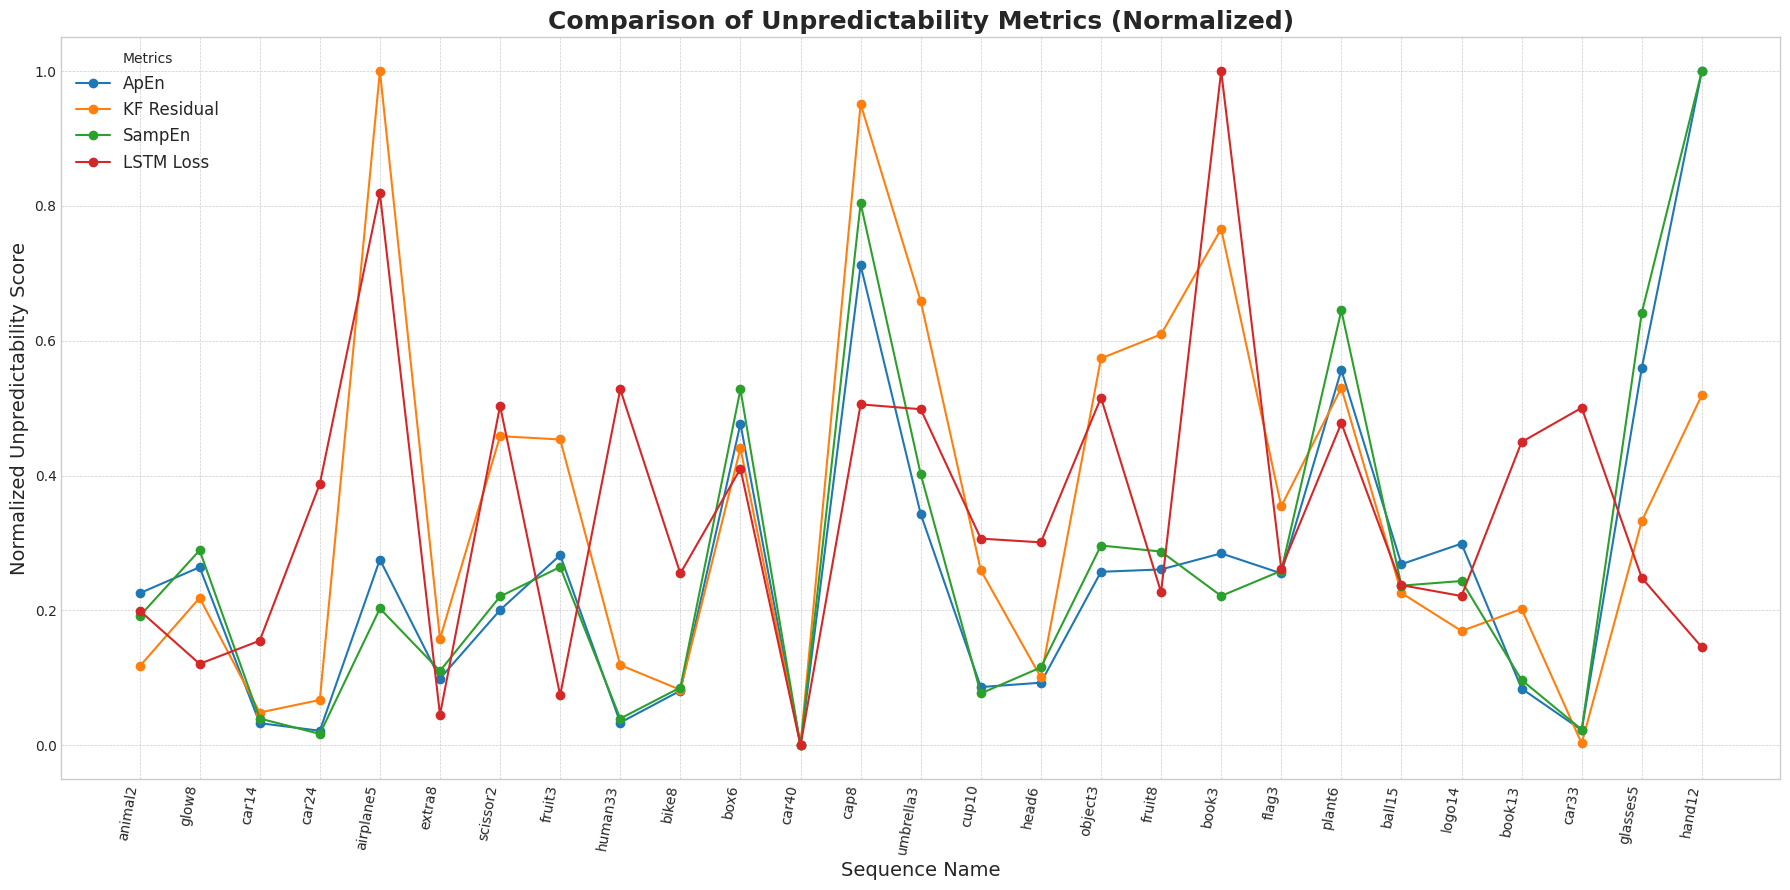

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================================================================
#  1. 配置部分 (请在这里修改您的设置)
# ==============================================================================

# a) 主序列列表，这将决定 X 轴的顺序
#    只有在这个列表中的序列才会被画出来。
sequence_names_in_order = [
    "animal2", "glow8", "car14", "car24", "airplane5", "extra8", "scissor2",
    "fruit3", "human33", "bike8", "box6", "car40", "cap8", "umbrella3",
    "cup10", "head6", "object3", "fruit8", "book3", "flag3", "plant6",
    "ball15", "logo14", "book13", "car33", "glasses5", "hand12"
]

# b) 指定您要处理的结果文件
#    为每个文件提供一个 'name' (将显示在图例中) 和 'path' (文件的完整路径)。
files_to_process = [
    {
        'name': 'ApEn',
        'path': './ESOT500-L/apen_results.txt'
    },
    {
        'name': 'KF Residual',
        'path': './ESOT500-L/kf_results.txt'
    },
    {
        'name': 'SampEn',
        'path': './ESOT500-L/sampen_results.txt'
    },
    {
        'name': 'LSTM Loss',
        'path': './ESOT500-L/lstm_loss_results.txt'
    }
    # 您可以根据需要添加更多文件...
    # {'name': 'New Metric', 'path': 'path/to/your/new_metric.txt'},
]

# c) 指定输出图表的路径和文件名
output_image_path = './ESOT500-L/final_comparison_plot.png'


# ==============================================================================
#  2. 辅助函数 (通常无需修改)
# ==============================================================================

def parse_results_file(file_path):
    """
    解析指定格式的结果文件，返回一个 {sequence_name: score} 的字典。
    """
    results_dict = {}
    if not os.path.exists(file_path):
        print(f"错误: 找不到文件 '{file_path}'。将跳过此文件。")
        return None
        
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            
            parts = line.strip().split(':', 1) # 使用 split(':', 1) 更安全
            if len(parts) == 2:
                seq_name = parts[0].strip()
                try:
                    score_str = parts[1].strip()
                    score = np.inf if score_str.lower() == 'inf' else float(score_str)
                    results_dict[seq_name] = score
                except ValueError:
                    print(f"警告: 无法解析文件 '{file_path}' 中 '{seq_name}' 的分数。跳过该行。")
    return results_dict

def normalize_scores(scores):
    """
    使用 Min-Max 归一化将分数缩放到 [0, 1] 区间。
    特殊处理 inf 值。
    """
    scores_array = np.array(scores, dtype=float)
    
    # 如果没有有效数字，则返回原数组
    if not np.any(np.isfinite(scores_array)):
        return scores_array
        
    finite_max = np.max(scores_array[np.isfinite(scores_array)])
    scores_array[np.isinf(scores_array)] = finite_max
    
    min_val = np.min(scores_array)
    max_val = np.max(scores_array)
    
    if max_val == min_val:
        return np.full_like(scores_array, 0.5)
        
    return (scores_array - min_val) / (max_val - min_val)

# ==============================================================================
#  3. 主执行逻辑
# ==============================================================================

def main():
    """
    执行所有解析、处理和绘图的步骤。
    """
    # 检查路径是否为默认值
    if any("path/to/your" in f['path'] for f in files_to_process) or "path/to/your" in output_image_path:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! 错误：请先在代码顶部的配置部分修改文件路径。     !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return

    # --- 步骤 1: 解析所有文件 ---
    print("--- 1/4: 正在解析结果文件 ---")
    all_parsed_data = {}
    for file_info in files_to_process:
        metric_name = file_info['name']
        file_path = file_info['path']
        print(f"  正在读取: {metric_name} ({file_path})")
        parsed_data = parse_results_file(file_path)
        if parsed_data is not None:
            all_parsed_data[metric_name] = parsed_data

    # --- 步骤 2: 按指定顺序整理数据 ---
    print("\n--- 2/4: 正在按指定顺序整理数据 ---")
    plot_data = {metric_name: [] for metric_name in all_parsed_data.keys()}
    
    for seq_name in sequence_names_in_order:
        for metric_name, results_dict in all_parsed_data.items():
            score = results_dict.get(seq_name, np.nan)
            if np.isnan(score):
                print(f"  -> 警告: 在 '{metric_name}' 的结果中未找到序列 '{seq_name}'。")
            plot_data[metric_name].append(score)
            
    # --- 步骤 3: 对每个指标的数据进行归一化 ---
    print("\n--- 3/4: 正在对分数进行归一化处理 ---")
    normalized_plot_data = {}
    for metric_name, scores in plot_data.items():
        normalized_scores = normalize_scores(scores)
        normalized_plot_data[metric_name] = normalized_scores
        print(f"  '{metric_name}' 的数据已归一化。")

    # --- 步骤 4: 创建并绘制图表 ---
    print("\n--- 4/4: 正在生成图表 ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 9))

    for metric_name, norm_scores in normalized_plot_data.items():
        # 使用 numpy.array 来方便地处理 nan 值 (matplotlib 会自动在 nan 处断开线条)
        ax.plot(sequence_names_in_order, np.array(norm_scores), marker='o', linestyle='-', label=metric_name)

    ax.set_title('Comparison of Unpredictability Metrics (Normalized)', fontsize=18, fontweight='bold')
    ax.set_xlabel('Sequence Name', fontsize=14)
    ax.set_ylabel('Normalized Unpredictability Score', fontsize=14)
    
    plt.xticks(rotation=80, ha='right', fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    ax.legend(fontsize=12, title='Metrics')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylim(-0.05, 1.05) # 设置 Y 轴范围略大于 [0,1] 以便观察
    
    plt.tight_layout()

    try:
        # 确保输出目录存在
        output_dir = os.path.dirname(output_image_path)
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            
        plt.savefig(output_image_path, dpi=300)
        print(f"\n--- 图表已成功保存到 '{output_image_path}' ---")
    except Exception as e:
        print(f"\n错误: 无法保存图表: {e}")

    plt.show()

if __name__ == "__main__":
    main()

下述将计算上述指标与不可预测性ground truth之间的相关性。
注意：这里的不可预测性ground truth来源于 Bridging the Latency Gap with a Continuous Stream Evaluation Framework in Event-Driven Perception 原文，它用一种叫做Predictive Tracking的方法在数据集上跑，然后对于其与baseline的效果，Predictive Tracking的效果越好，说明对应的序列样本可预测性越强，反之越差。

In [1]:
import numpy as np
import os

# ==============================================================================
#  1. 配置部分
# ==============================================================================

# CSV 文件的路径
csv_file_path = './ESOT500-L/high_dynamic_gt.csv' 


# 待比较的 TXT 文件列表
txt_files_to_compare = [
    {'name': 'ApEn',        'path': './ESOT500-L/apen_results.txt'},
    {'name': 'KF Residual', 'path': './ESOT500-L/kf_results.txt'},
    {'name': 'SampEn',      'path': './ESOT500-L/sampen_results.txt'},
    {'name': 'LSTM Loss',   'path': './ESOT500-L/lstm_loss_results.txt'}
]

# ==============================================================================
#  2. 数据读取辅助函数
# ==============================================================================

def read_csv_data(file_path):
    """
    读取 CSV 文件，返回 {sequence_name: value} 字典。
    假设第一行是标题，格式为: sequence_name,difference
    """
    data_dict = {}
    if not os.path.exists(file_path):
        print(f"[错误] CSV 文件不存在: {file_path}")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # 读取所有行
            lines = f.readlines()
            
            # 跳过第一行（Header）
            # 如果你的CSV没有header，请注释掉下面这行
            lines = lines[1:] 

            for line in lines:
                line = line.strip()
                if not line: continue
                
                # 使用逗号分割
                parts = line.split(',')
                if len(parts) >= 2:
                    seq_name = parts[0].strip()
                    try:
                        val = float(parts[1].strip())
                        data_dict[seq_name] = val
                    except ValueError:
                        print(f"[警告] CSV中无法解析数值: {line}")
    except Exception as e:
        print(f"[错误] 读取 CSV 失败: {e}")
        return None
        
    return data_dict

def read_txt_data(file_path):
    """
    读取 TXT 文件 (之前代码中的 parse_results_file 逻辑)，
    返回 {sequence_name: value} 字典。
    """
    data_dict = {}
    if not os.path.exists(file_path):
        print(f"[错误] TXT 文件不存在: {file_path}")
        return None

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            
            # 使用冒号分割
            parts = line.split(':', 1)
            if len(parts) == 2:
                seq_name = parts[0].strip()
                try:
                    score_str = parts[1].strip()
                    # 处理 inf
                    score = np.inf if score_str.lower() == 'inf' else float(score_str)
                    data_dict[seq_name] = score
                except ValueError:
                    pass
    return data_dict

# ==============================================================================
#  3. 计算相关性逻辑
# ==============================================================================

def calculate_correlation(base_dict, target_dict, target_name):
    """
    计算两个字典中相同 Key 对应的 Value 的皮尔逊相关系数 (Pearson Correlation)。
    """
    # 1. 找到两个字典共有的 Key (序列名)
    common_keys = sorted(list(set(base_dict.keys()) & set(target_dict.keys())))
    
    if len(common_keys) < 2:
        print(f"  -> {target_name}: [无法计算] 共同的序列数量太少 ({len(common_keys)}个)")
        return

    # 2. 提取对其后的数值列表
    list_base = []
    list_target = []
    
    skipped_count = 0
    
    for key in common_keys:
        val1 = base_dict[key]
        val2 = target_dict[key]
        
        # 3. 过滤掉 inf 或 nan，因为它们无法计算相关性
        if np.isfinite(val1) and np.isfinite(val2):
            list_base.append(val1)
            list_target.append(val2)
        else:
            skipped_count += 1

    if len(list_base) < 2:
        print(f"  -> {target_name}: [无法计算] 有效数值(非inf/nan)太少")
        return

    # 4. 使用 numpy 计算皮尔逊相关系数矩阵
    # corrcoef 返回的是矩阵 [[1, r], [r, 1]]，我们需要取出 [0,1] 也就是 r
    correlation_matrix = np.corrcoef(list_base, list_target)
    pearson_r = correlation_matrix[0, 1]

    print(f"  -> 与 [{target_name:<11}] 的相关性: {pearson_r:.4f} (基于 {len(list_base)} 个共同序列)")

# ==============================================================================
#  4. 主程序
# ==============================================================================

def main():
    print("--- 1. 读取基准 CSV 文件 ---")
    csv_data = read_csv_data(csv_file_path)
    
    if not csv_data:
        return

    print(f"成功读取 CSV，共 {len(csv_data)} 条数据。\n")

    print("--- 2. 读取 TXT 文件并计算相关性 ---")
    print(f"正在计算 'CSV数值' (Difference) 与以下指标的相关性:\n")
    
    for txt_info in txt_files_to_compare:
        name = txt_info['name']
        path = txt_info['path']
        
        # 读取 TXT
        txt_data = read_txt_data(path)
        
        if txt_data:
            # 计算相关性
            calculate_correlation(csv_data, txt_data, name)
        else:
            print(f"  -> {name}: 读取失败或文件为空")

if __name__ == "__main__":
    main()

--- 1. 读取基准 CSV 文件 ---
成功读取 CSV，共 27 条数据。

--- 2. 读取 TXT 文件并计算相关性 ---
正在计算 'CSV数值' (Difference) 与以下指标的相关性:

  -> 与 [ApEn       ] 的相关性: -0.5752 (基于 27 个共同序列)
  -> 与 [KF Residual] 的相关性: -0.0144 (基于 27 个共同序列)
  -> 与 [SampEn     ] 的相关性: -0.5471 (基于 27 个共同序列)
  -> 与 [LSTM Loss  ] 的相关性: 0.0846 (基于 27 个共同序列)


由上述代码的结果可知：Learning-based Metric (taking LSTM as an example) 相比于hand-coded rule-based metric更能衡量系统状态序列的不可预测性。